# Metoda najmniejszych kwadratów

(Dzmitry, Nikitsin, Gr6)

#### Krótkie wprowadzenie

Naszym celem w metodzie najmniejszych kwadratów jest znalezienie takiego wektora parametrów $\mathbf{x}$, który minimalizuje błąd dopasowania modelu do danych. Błąd ten definiujemy jako **sumę kwadratów różnic** między wartościami rzeczywistymi $\mathbf{b}$ a przewidywanymi $A\mathbf{x}$ czyli mówiąc prościej szukamy minimalny błąd średniokwadratowy:

$$L(\mathbf{x}) = \sum_{i=1}^{m} (y_i - (A\mathbf{x})_i)^2 \to min$$

Powyższa suma to nic innego jak kwadrat normy euklidesowej (długości) wektora różnic. Możemy więc zapisać to używając wektora wyników $\mathbf{b}$ (zawierającego $y_i$) oraz macierzy danych $A$:

$$L(\mathbf{x}) = ||\mathbf{b} - A\mathbf{x}||^2$$

Korzystając z własności iloczynu skalarnego wektorów ($\mathbf{v} \cdot \mathbf{v} = \mathbf{v}^T \mathbf{v}$), zapisujemy funkcję w postaci algebraicznej:

$$(\mathbf{b} - A\mathbf{x})^T (\mathbf{b} - A\mathbf{x})$$

Po otwarciu nawiasów ostatecznie dostajemy funkcję, która jest łatwa do zminimalizowania:
$$L(\mathbf{x}) = \mathbf{b}^T \mathbf{b} - 2\mathbf{x}^T A^T \mathbf{b} + \mathbf{x}^T A^T A \mathbf{x}$$

Aby znaleźć minimum tej funkcji, musimy obliczyć jej **gradient** względem wektora $\mathbf{x}$ i przyrównać go do zera. Gradient $\nabla_{\mathbf{x}} L$ to w rzeczywistości wektor składający się ze wszystkich **pochodnych cząstkowych** funkcji po poszczególnych zmiennych $x_1, x_2, \dots, x_n$:

$$
\nabla_{\mathbf{x}} L(\mathbf{x}) =
\begin{bmatrix}
\frac{\partial L}{\partial x_1} \\
\frac{\partial L}{\partial x_2} \\
\vdots \\
\frac{\partial L}{\partial x_n}
\end{bmatrix}
$$

Każda pochodna cząstkowa $\frac{\partial L}{\partial x_k}$ mówi nam, jak zmienia się błąd, gdy zmieniamy tylko jeden parametr $x_k$. W minimum wszystkie te zmiany muszą wynosić zero jednocześnie. Obliczając gradient (czyli wykonując operacje pochodnych cząstkowych na całym wektorze jednocześnie), otrzymujemy:
1. Pochodna wyrazu wolnego $\mathbf{b}^T\mathbf{b}$ wynosi $0$.
2. Pochodna wyrazu liniowego $-2\mathbf{x}^T A^T \mathbf{b}$ wynosi $-2A^T \mathbf{b}$.
3. Pochodna wyrazu kwadratowego $\mathbf{x}^T A^T A \mathbf{x}$ wynosi $2A^T A \mathbf{x}$.

Stawiamy warunek konieczny istnienia minimum ($\nabla_{\mathbf{x}} L = 0$):

$$-2A^T \mathbf{b} + 2A^T A \mathbf{x} = 0$$

Po przekształceniu otrzymujemy **Układ Równań Normalnych**:
$$A^T A \mathbf{x} = A^T \mathbf{b}$$

Mnożąc lewostronnie przez odwrotność macierzy $(A^T A)^{-1}$, otrzymujemy szukany wzór na $\mathbf{x}$:
$$\mathbf{x} = \underbrace{(A^T A)^{-1} A^T}_{A^+} \mathbf{b}$$

Wyrażenie $(A^T A)^{-1} A^T$ nazywamy **macierzą pseudoodwrotną Moore’a-Penrose’a** ($A^+$). Pozwala ona rozwiązać problem minimalizacji sumy kwadratów błędów jednym działaniem macierzowym.


In [46]:
import numpy as np
from scipy.stats import alpha


def pinvMP(A):
    """
    Oblicza macierz pseudoodwrotną Moore’a-Penrose’a dla macierzy A,
    korzystając z powyżej wyprowadzonego wzoru

    Zastosowanie:
    Używana do rozwiązywania nadokreślonych układów równań Ax=b
    w sensie najmniejszych kwadratów: x = A^+ b.

    :param A -- macierz numpy o wymiarach (m, n), gdzie m >= n
    :return A_pinv -- macierz pseudoodwrotna o wymiarach (n, m)
    :raise ValueError -- w przypadku, jezeli macierz jest nieodwracalna
    """

    A_T = A.T
    ATA = A_T @ A

    # Odwrócenie macierzy (A^T * A)
    try:
        ATA_inv = np.linalg.inv(ATA)
    except np.linalg.LinAlgError:
        raise ValueError("Macierz A^T A jest nieodwracalna")

    A_pinv = ATA_inv @ A_T

    return A_pinv

> **Komentarz dotyczący stabilności numerycznej:**
>
> Zaimplementowane powyżej rozwiązanie korzystające z jawnego wyznaczenia macierzy $(A^T A)^{-1}$ jest poprawne teoretycznie (algebraicznie), jednak w praktyce inżynierskiej jest uznawane za mniej stabilne numerycznie.
>
> Głównym powodem jest operacja obliczania iloczynu $A^T A$, która powoduje podniesienie do kwadratu wskaźnika uwarunkowania macierzy ($\kappa(A^T A) \approx \kappa(A)^2$). W przypadku macierzy źle uwarunkowanych (ill-conditioned), może to prowadzić do drastycznej utraty precyzji obliczeń zmiennoprzecinkowych lub błędów typu `Singular Matrix Error`, nawet jeśli wyjściowy problem jest rozwiązywalny.
>
> W bibliotekach numerycznych (jak LAPACK/NumPy) preferowane są metody omijające bezpośrednie tworzenie macierzy $A^T A$, takie jak rozkład QR (patrz Zadanie 2) lub SVD (używane domyślnie w `np.linalg.pinv`), które zachowują pierwotny wskaźnik uwarunkowania $\kappa(A)$.

---

#### ZADANIE 1
Zapiszmy nadokreślony układ równań za pomocą macierzy $A: Ax=b$. Zaimplementuj rozwiązanie problemu aproksymacji liniowej za pomocą metody najmniejszych kwadratów. Do wyznaczenia rozwiązania wykorzystaj macierz pseudoodwrotną Moore’a-Penrose’a


In [47]:
def solve_LSQ_with_MoorePenrose_matrix(A, b):
    """
    Rozwiązuje problem najmniejszych kwadratów przy użyciu macierzy pseudoodwrotnej Moore’a-Penrose’a.
    Ax = b -> x = A^+ b, gdzie A^+ jest macierzą pseudoodwrotną Moore’a-Penrose’a dla macierzy A.

    Funkcja oddelegowuje obliczenie A^+ do funkcji pomocniczej pinvMP.

    :param A: tablica 2D (array-like), macierz współczynników układu.
    :param b: tablica 1D lub 2D (array-like), wektor(y) zmiennych zależnych.
    :return: tablica 1D lub 2D reprezentująca rozwiązanie x układu Ax = b.
    """

    #A^+
    A_pseudo_inv = pinvMP(A)

    x = A_pseudo_inv @ b
    return x



---
#### ZADANIE 2
Zaimplementuj rozwiązanie problemu OLS przy pomocy macierzy pseudoodwrotnej Moore’a-Penrose’a zapisanej za pomocą macierzy Q i R uzyskanych z rozkładu oryginalnej macierzy $A$. Wykorzystaj w tym celu właśności macierzy oraz rozkładu QR.



**Wyprowadzenie macierzy pseudoodwrotnej za pomoca macierzy Q i R**


Z wyżej napisanego definicja macierzy pseudoodwrotnej to:
$$A^+ = (A^T A)^{-1} A^T$$


Wiemy, że $A = QR$.
Dla macierzy prostokątnej $A$ ($m \times n, m \ge n$), stosujemy tzw. **zredukowany rozkład QR**, gdzie:
* $Q$ jest macierzą ortonormalną o wymiarach $m \times n$ (ma własność $Q^T Q = I$).
* $R$ jest macierzą górnotrójkątną kwadratową $n \times n$ (jest odwracalna, jeśli $A$ ma pełny rząd).

Podstawiamy $A = QR$ do wzoru na $A^+$:
$$A^+ = ((QR)^T (QR))^{-1} (QR)^T = (R^T Q^T Q R)^{-1} R^T Q^T = (R^T I R)^{-1} R^T Q^T =$$
$$ = (R^T R)^{-1} R^T Q^T = R^{-1} (R^T)^{-1} R^T Q^T = R^{-1} I Q^T $$

**Wynik końcowy:**
$$A^+ = R^{-1} Q^T$$

Zatem nasze rozwiązanie $x = A^+b$ przyjmuje postać:
$$x = R^{-1} Q^T b$$



In [48]:
def solve_LSQ_with_QR(A, b):
    """
    Rozwiązuje problem OLS przy pomocy rozkładu QR i wyznaczenia
    macierzy pseudoodwrotnej z wzoru A^+ = R^-1 * Q^T.

    :param A: tablica 2D (array-like), macierz współczynników układu.
    :param b: tablica 1D lub 2D (array-like), wektor(y) zmiennych zależnych.
    :return: tablica 1D lub 2D reprezentująca rozwiązanie x układu Ax = b <=> (R^-1 * Q^T)x = b
    """
    # Q,R (mode='reduced' ->  R kwadratowe (n x n))
    Q, R = np.linalg.qr(A, mode='reduced')

    #R^-1
    R_inv = np.linalg.inv(R)

    #A^+
    A_pinv = R_inv @ Q.T

    x = A_pinv @ b
    return x

---
#### ZADANIE 4
Wygeneruj przykładowe zaszumione próbki funkcji wielomianowej jednej zmiennej. Liczba próbek powinna wynosić ok. 100 dla przedziału o długości 10. Niech będzie to wielomian co najmniej siódmego stopnia. Za pomocą implementacji metod najmniejszych kwadratów z 1. i 2. punktu znajdź funkcje aproksymujące te dane. Dobierz odpowiedni stopień wielomianu i porównaj otrzymane wyniki. Do porównania, oprócz sumy kwadratu błędów wykorzystaj trzy inne metryki (np. błąd średniokwadratowy).

eeAby dopasować wielomian stopnia $d$ postaci:
$$y = w_0 + w_1x + w_2x^2 + \dots + w_dx^d$$
za pomocą metod zaimpelementowanych z `zad.1` oraz `zad.2`, przekształcono wektor wejściowy $x$ w **macierz Vandermonde’a**. Dla $m$ próbek wygląda ona następująco:

$$
A =
\begin{bmatrix}
1 & x_1 & x_1^2 & \dots & x_1^d \\
1 & x_2 & x_2^2 & \dots & x_2^d \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_m & x_m^2 & \dots & x_m^d
\end{bmatrix}
$$

Wtedy wektor $w = [w_0, w_1, \dots, w_d]^T$ zawiera szukane współczynniki wielomianu.



### Metryki oceny modelu
Do porównania jakości dopasowania dla różnych stopni wielomianu wykorzystano następujące metryki, gdzie $y_i$ to wartość rzeczywista, a $\hat{y}_i$ to wartość przewidziana przez model:

1.  **SSE (Sum of Squared Errors):** Suma kwadratów błędów.
    $$SSE = \sum_{i=1}^m (y_i - \hat{y}_i)^2$$
2.  **MSE (Mean Squared Error):** Błąd średniokwadratowy.
    $$MSE = \frac{1}{m} SSE$$
3.  **RMSE (Root Mean Squared Error):** Pierwiastek błędu średniokwadratowego.
    $$RMSE = \sqrt{MSE}$$
4.  **MAE (Mean Absolute Error):** Średni błąd bezwzględny.
    $$MAE = \frac{1}{m} \sum_{i=1}^m |y_i - \hat{y}_i|$$

-------

W celu weryfikacji poprawności zaimplementowanych metod aproksymacji, jako funkcję bazową do generowania danych wybrano **Wielomian Czebyszewa pierwszego rodzaju stopnia 8**, oznaczany jako $T_8(x)$.

#### Dlaczego ten wybór?
Wielomiany Czebyszewa odgrywają fundamentalną rolę w teorii aproksymacji ze względu na swoje unikalne własności:
1.  **Silna oscylacja (Stress-test):** Wielomian $T_n(x)$ w przedziale $[-1, 1]$ posiada $n$ miejsc zerowych oraz $n+1$ ekstremów lokalnych, przyjmujących na przemian wartości $-1$ i $1$. Dla stopnia 8 oznacza to bardzo dużą zmienność funkcji (gęste "falowanie"). Jest to doskonały test dla algorytmu regresji – sprawdza, czy model potrafi uchwycić skomplikowaną strukturę danych, czy też ulegnie zjawisku *underfittingu* (wygładzenia).
2.  **Własność minimaksowa:** Użycie funkcji o charakterystyce Czebyszewa pozwala na analizę zachowania modelu na krańcach przedziału, gdzie standardowe wielomiany (w bazie potęgowej) często wykazują niestabilność (efekt Rungego).

#### Definicja matematyczna
Wielomiany Czebyszewa definiowane są rekurencyjnie:
$$T_0(x) = 1$$
$$T_1(x) = x$$
$$T_{n+1}(x) = 2xT_n(x) - T_{n-1}(x)$$

W naszym eksperymencie użyjemy wielomianu $T_8(x)$, który po rozwinięciu do bazy potęgowej przyjmuje postać:
$$T_8(x) = 128x^8 - 256x^6 + 160x^4 - 32x^2 + 1$$

Eksperyment zostanie przeprowadzony na znormalizowanym przedziale $x \in [-1, 1]$, z dodanym szumem losowym o rozkładzie normalnym, aby zasymulować rzeczywiste warunki pomiarowe.

In [54]:
import matplotlib.pyplot as plt
from numpy.polynomial import Chebyshev


# funkcja Generująca Dane (Wielomian Czebyszewa)
def generate_chebyshev_data(n_samples=100, noise_std=0.3):
    """
    Generuje zaszumione próbki na podstawie wielomianu Czebyszewa 8. stopnia (T8).
    :return: x (próbki), y_true (idealne), y_noisy (zaszumione)
    """
    #definicja wielomianu T8: [0,0,0,0,0,0,0,0,1] -> 1*T8
    #P(x) = 0 x T_0 + 0 x T_1 + ... + 0 x T_7 + 1 x T_8(x)
    cheb_poly = Chebyshev([0] * 8 + [1])

    # 128x^8 - 256x^6 + 160x^4 - 32x^2 + 1
    p_true = cheb_poly.convert(kind=np.polynomial.Polynomial)

    # generowanie próbek w naturalnym przedziale Czebyszewa [-1, 1]
    x = np.linspace(-1, 1, n_samples)
    y_ideal = p_true(x)

    # szum
    np.random.seed(13)
    noise = np.random.normal(0, noise_std, size=len(x))
    y_noisy = y_ideal + noise

    return x, y_ideal, y_noisy


# funkcja Tworząca Macierz Vandermonde

def create_vandermonde_matrix(x, degree):
    """
    Tworzy macierz Vandermonde'a dla wektora x i zadanego stopnia wielomianu.
    Kolejność potęg: rosnąca (1, x, x^2, ..., x^d)
    Z w_0 * 1 + w_1 x + w_2 x^2 dla [x1, x2, ..., xd]
    tworzymy macierz postaci
    1  x1^1  x1^2  ... x1^d
    1  x2^1  x2^2  ... x2^d
    itd
    degree + 1 aby uwzględnic wyraz wolny
    """

    return np.vander(x, degree + 1, increasing=True)


# funkcja Obliczająca Metryki ---

def calculate_metrics(y_true, y_pred):
    """
    Oblicza zestaw metryk porównujących predykcję z danymi rzeczywistymi (lub zaszumionymi).
    :return słownik z wynikami: SSE, MSE, RMSE, MAE.
    """
    residuals = y_true - y_pred
    sse = np.sum(residuals ** 2)
    mse = np.mean(residuals ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(residuals))

    return {
        "SSE": sse,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae
    }


def run_polynomial_experiment(degrees, x, y_noisy, y_ideal):
    """
    Przeprowadza serię aproksymacji dla różnych stopni wielomianu.
    Rysuje wykres i wypisuje tabelę metryk.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    # rysowanie danych bazowych
    ax1.scatter(x, y_noisy, color='gray', label='Pomiary zaszumione')
    ax1.plot(x, y_ideal, 'k--', linewidth=2, label='Oryginał (T8)')
    ax2.axhline(0, color='black', linestyle='--', linewidth=1, label='Błąd zerowy')
    colors = ['salmon', 'turquoise', 'orange', 'purple']

    for i, deg in enumerate(degrees):
        #tworzenie macierzy Vandermonde -> A(vander)
        A = create_vandermonde_matrix(x, deg)

        #rozwiązanie układy Ax = b -> x
        coffs = solve_LSQ_with_MoorePenrose_matrix(A, y_noisy)

        # obliczenie wartości przewidywanych (y = Aw) z celu narysowania wykresu
        y_pred = A @ coffs

        # obliczenie metryk
        m = calculate_metrics(y_noisy, y_pred)
        print(
            f"{i + 1}. stopień: {deg}, SSE: {m['SSE']:.4f}, MSE: {m['MSE']:.4f}, RMSE: {m['RMSE']:.4f}, MAE: {m['MAE']:.4f}")
        ax1.plot(x, y_pred, color=colors[i], linewidth=2, label=f'Aproksymacja st. {deg}')
        residuals = y_noisy - y_pred
        ax2.scatter(x, residuals, color=colors[i], label=f'Err st. {deg}')

    # Finalizacja wykresu
    ax1.set_title("Dopasowanie modeli wielomianowych")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Prawy wykres
    ax2.set_title("Wykres Rezyduów (y_noisy - y_pred)")
    ax2.set_xlabel("x")
    ax2.set_ylabel("Wartość błędu")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    fig.tight_layout() # Ładnie układa odstępy między wykresami

1. stopień: 4, SSE: 57.1466, MSE: 0.5715, RMSE: 0.7560, MAE: 0.6628
2. stopień: 8, SSE: 7.4177, MSE: 0.0742, RMSE: 0.2724, MAE: 0.2187
3. stopień: 12, SSE: 7.1671, MSE: 0.0717, RMSE: 0.2677, MAE: 0.2189


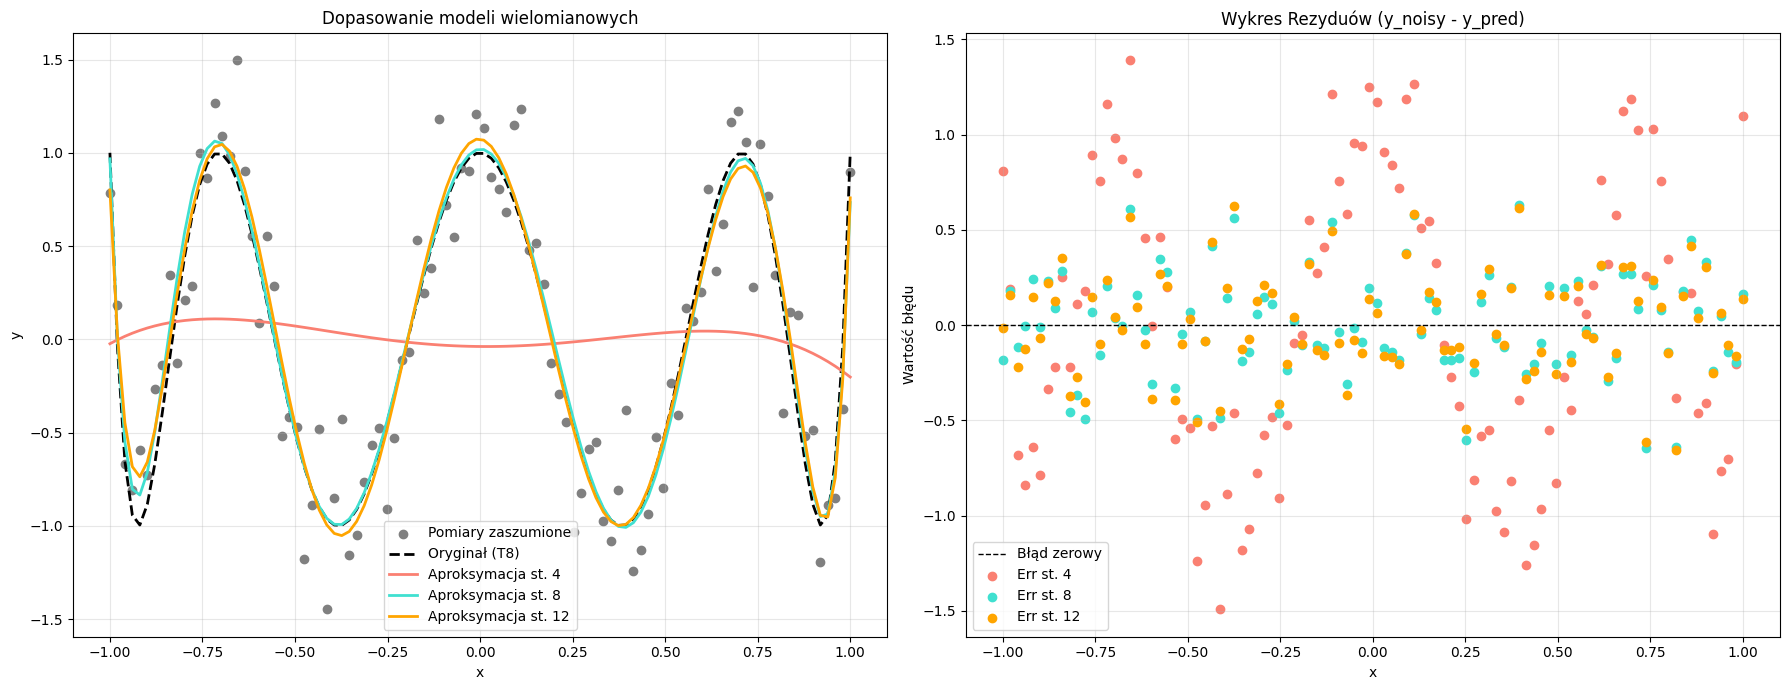

In [55]:
x_samples, y_true, y_data = generate_chebyshev_data(n_samples=100, noise_std=0.3)
degrees_to_test = [4, 8, 12]
run_polynomial_experiment(degrees_to_test, x_samples, y_data, y_true)


### Wnioski z analizy aproksymacji wielomianowej

Na podstawie przeprowadzonego eksperymentu, analizy wykresu oraz zestawienia metryk błędów (SSE, MSE, RMSE, MAE), można sformułować następujące obserwacje dotyczące doboru stopnia wielomianu:

**1. Niedopasowanie modelu (Underfitting) – Stopień 4**
* **Analiza wizualna:** Zielona krzywa na wykresie jest zbyt gładka i nie potrafi odwzorować częstotliwości oscylacji oryginalnej funkcji (Wielomianu Czebyszewa $T_8$). Model ignoruje większość ekstremów lokalnych.
* **Analiza metryk:** Błędy dla tego stopnia są o rząd wielkości wyższe niż dla pozostałych (MSE $\approx 0.57$ vs $0.07$). Wskazuje to na zbyt małą pojemność modelu (zbyt niską wariancję, zbyt wysokie obciążenie). Model nie jest w stanie uchwycić struktury danych.

**2. Optymalne dopasowanie – Stopień 8**
* **Analiza wizualna:** Niebieska krzywa niemal idealnie pokrywa się z linią przerywaną oznaczającą prawdziwą funkcję (oryginał). Model poprawnie odtwarza wszystkie "górki i dołki" funkcji $T_8$.
* **Analiza metryk:** Nastąpił drastyczny spadek błędu średniokwadratowego (MSE) z poziomu $0.57$ do $0.074$. Jest to wynik oczekiwany, ponieważ stopień modelu (8) jest zgodny ze stopniem wielomianu generującego dane. Jest to punkt optymalny.

**3. Ryzyko przeuczenia (Overfitting) – Stopień 12**
* **Analiza metryk:** Wielomian 12. stopnia osiągnął najniższe wartości błędów (SSE $\approx 7.16$), jednak poprawa względem stopnia 8. jest marginalna (zaledwie o ok. 3%).
* **Interpretacja:** Spadek błędu wynika z faktu, że model o wyższym stopniu ma większą swobodę i zaczyna dopasowywać się do losowego szumu pomiarowego ($\epsilon$), a nie tylko do użytecznego sygnału. Zwiększanie stopnia wielomianu powyżej rzędu rzeczywistej funkcji nie przynosi korzyści w odwzorowaniu trendu, a zwiększa koszt obliczeniowy i ryzyko niestabilności na krańcach przedziału.
---

#### ZADANIE 5
W samodzielnie wybranym zbiorze danych znajdź liniową zależność opisującą wartość jednego z atrybutów w funkcji kombinacji liniowej pozostałych. Podziel znaleziony zbiór na dwie części: zbiór treningowy (uczący) i zbiór testowy. Do danych treningowych dopasuj funkcję aproksymującą i sprawdź dokładność modelu w zbiorze testowym.

W tym zadaniu analizujemy zbiór danych opisujący cechy fizyczne ryb. Naszym celem jest znalezienie liniowej zależności pozwalającej przewidzieć **wagę ryby (Weight)** na podstawie jej wymiarów geometrycznych.

Zbiór danych zawiera następujące atrybuty:
* **Zmienna celu ($y$):** `Weight` (Waga w gramach)
* **Zmienne objaśniające ($x_1, \dots, x_5$):**
    * `Length1` (Długość standardowa)
    * `Length2` (Długość w widelcu)
    * `Length3` (Długość całkowita)
    * `Height` (Wysokość)
    * `Width` (Szerokość)

Atrybut `Species` (Gatunek) jest wartością kategoryczną (tekstową) i zostanie pominięty w prostym modelu regresji liniowej, który opiera się na zależnościach liczbowych.

### Model matematyczny
Szukamy wektora współczynników $w = [w_0, w_1, w_2, w_3, w_4, w_5]^T$, który minimalizuje błąd dopasowania w równaniu:

$$\text{Weight} \approx w_0 + w_1 \cdot \text{L1} + w_2 \cdot \text{L2} + w_3 \cdot \text{L3} + w_4 \cdot \text{H} + w_5 \cdot \text{W}$$

Macierz planu $A$ dla $m$ próbek, po uwzględnieniu wyrazu wolnego (bias, $w_0$), przyjmuje postać:

$$
A =
\begin{bmatrix}
1 & \text{Length1}_1 & \text{Length2}_1 & \text{Length3}_1 & \text{Height}_1 & \text{Width}_1 \\
1 & \text{Length1}_2 & \text{Length2}_2 & \text{Length3}_2 & \text{Height}_2 & \text{Width}_2 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
1 & \text{Length1}_m & \text{Length2}_m & \text{Length3}_m & \text{Height}_m & \text{Width}_m
\end{bmatrix}
$$

Zbiór zostanie podzielony na część treningową (do wyznaczenia $w$) i testową (do weryfikacji).


In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("data/Fish.csv")
df

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...,...
154,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
155,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690
156,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558
157,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672


In [56]:
#Przygotowanie danych

x = df[df.columns[2:]]
y = df[df.columns[1]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=13)
A_train = np.c_[np.ones(len(x_train)), x_train]
A_test = np.c_[np.ones(len(x_test)), x_test]

SSE: 1378993.3215
MSE: 12423.3633
RMSE: 111.4601
MAE: 85.1257


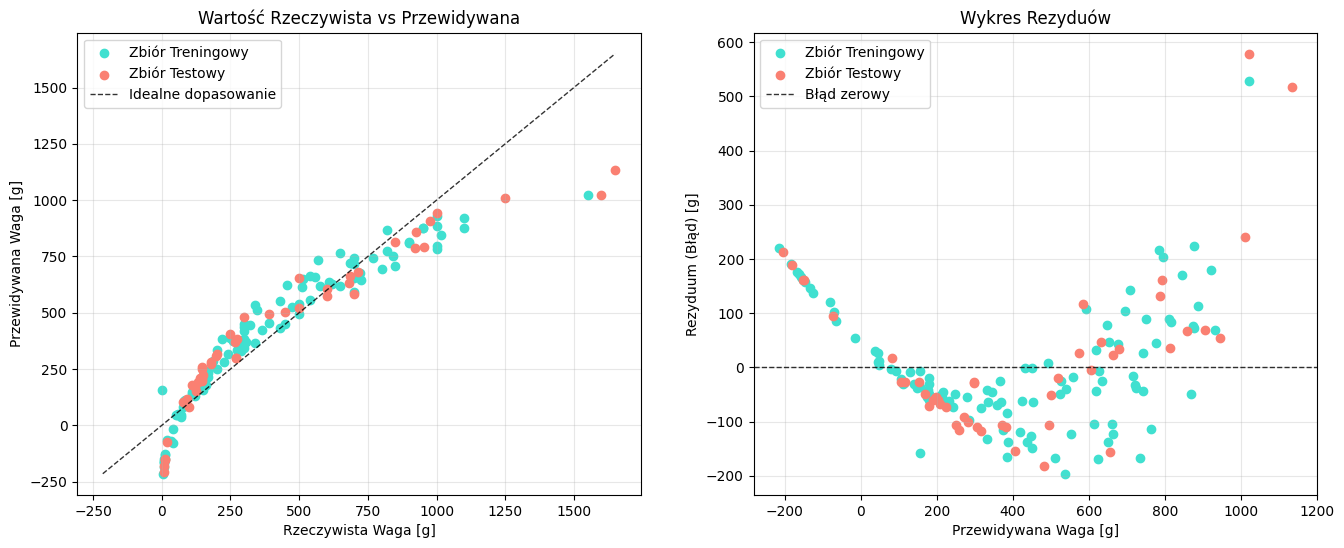

In [57]:
w = solve_LSQ_with_MoorePenrose_matrix(A_train, y_train)

y_pred_train = A_train @ w
y_pred_test = A_test @ w

residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

# metryki
metrics = calculate_metrics(y_train, y_pred_train)

print(f"SSE: {metrics['SSE']:.4f}")
print(f"MSE: {metrics['MSE']:.4f}")
print(f"RMSE: {metrics['RMSE']:.4f}")
print(f"MAE: {metrics['MAE']:.4f}")

#plot1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.scatter(y_train, y_pred_train, color='turquoise', label='Zbiór Treningowy')
ax1.scatter(y_test, y_pred_test, color='salmon', label='Zbiór Testowy')
all_vals = np.concatenate([y_train, y_test, y_pred_train, y_pred_test])
min_val, max_val = all_vals.min(), all_vals.max()
ax1.plot([min_val, max_val], [min_val, max_val], '--k', alpha=0.8, linewidth=1, label='Idealne dopasowanie')
ax1.set_title("Wartość Rzeczywista vs Przewidywana")
ax1.set_xlabel("Rzeczywista Waga [g]")
ax1.set_ylabel("Przewidywana Waga [g]")
ax1.legend()
ax1.grid(True, alpha=0.3)

#plot2
ax2.scatter(y_pred_train, residuals_train, color='turquoise', label='Zbiór Treningowy')
ax2.scatter(y_pred_test, residuals_test, color='salmon', label='Zbiór Testowy')
ax2.axhline(y=0, linestyle='--', color='black', alpha=0.8, linewidth=1, label='Błąd zerowy')
ax2.set_title("Wykres Rezyduów")
ax2.set_xlabel("Przewidywana Waga [g]")
ax2.set_ylabel("Rezyduum (Błąd) [g]")
ax2.legend()
ax2.grid(True, alpha=0.3)